# High active natural products

## loading data

In [1]:
import pandas as pd
from pysankey2 import Sankey
import sqlite3

from lib.plot import *

In [2]:
conn = sqlite3.connect('../data/iNP.db')

# load np_activities
sql = '''SELECT np_activities.*, lotusNP.pathway, lotusNP.superclass, lotusNP.class
            FROM np_activities LEFT JOIN lotusNP ON np_activities.lotus_id = lotusNP.lotus_id
            WHERE target_type = 'SINGLE PROTEIN' '''
np_act = pd.read_sql(sql, conn)

np_act['pathway'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
np_act['superclass'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)
np_act['class'].replace(to_replace=r'^\s*$', value='Other', regex=True, inplace=True)

np_act['pathway_superclass'] = np_act['pathway'] + ', ' + np_act['superclass']
np_act.sort_values(by=['pchembl_value'], ascending=False, inplace=True)
np_act.drop_duplicates(subset=['lotus_id','tid'], keep='first',inplace=True)
# np_act.drop_duplicates(subset=['lotus_id', 'pref_name'], keep='first',inplace=True)
print('np_activities: %d'%np_act.shape[0])

# np high active 
np_ha = np_act[np_act['pchembl_value'] > 8]
print('high active np: %d'%np_ha.shape[0])

# taxon family
family = pd.read_sql('SELECT * FROM family', conn)
print('taxon family: %d'%family.shape[0])

# taxon kingdom
kingdom = pd.read_sql('SELECT * FROM kingdom', conn)
print('taxon kingdom: %d'%family.shape[0])

# load lotus data
np = pd.read_sql('SELECT * FROM lotusNP', conn)
print('lotus: %d'%np.shape[0])

# loading ChEMBL drug mechanism
chembl = sqlite3.connect('../data/chembl_32.db')
mechanism = pd.read_sql('SELECT tid, mechanism_of_action FROM drug_mechanism', chembl)
mechanism.dropna(how='any', inplace=True)
mechanism['tid'] = mechanism['tid'].astype(int)
mechanism.drop_duplicates(inplace=True)
print('mechanism: %d'%mechanism.shape[0])

np_activities: 93655
high active np: 825
taxon family: 412662
taxon kingdom: 412662
lotus: 276518
mechanism: 1847


## Hit rate of high activity 
- hit rate for high activities

In [3]:
count_act = np_act.value_counts(subset=['pathway_superclass']).reset_index()
count_ha = np_ha.value_counts(subset=['pathway_superclass']).reset_index()

hit_rate = pd.merge(count_ha, count_act, how='left', on='pathway_superclass')
hit_rate['percentage'] = round(100*hit_rate['count_x']/hit_rate['count_y'],2)
hit_rate.sort_values(by=['percentage'],ascending=False, inplace=True)
hit_rate.to_csv('../plot/4-hit_rate.csv',index=False)

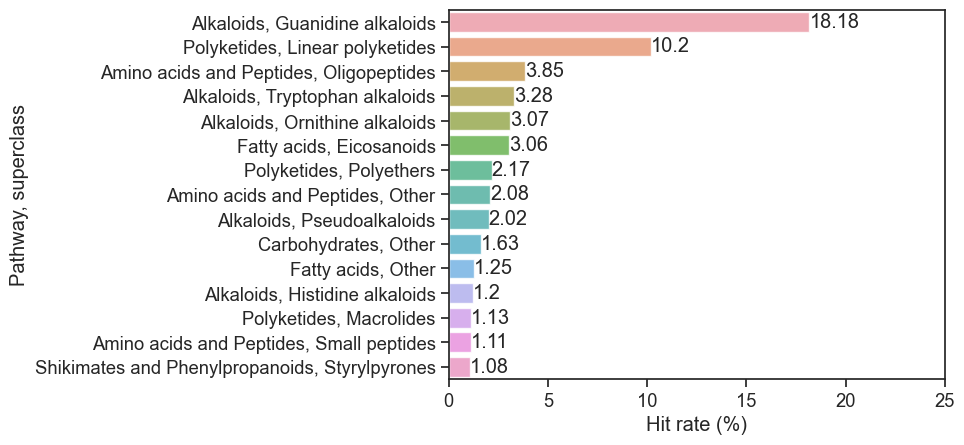

In [4]:
fig = bar(hit_rate[hit_rate['percentage'] > 1], x='percentage', y='pathway_superclass', xlim=(0, 25))
fig.set(xlabel='Hit rate (%)', ylabel = 'Pathway, superclass')
fig.figure.savefig('../plot/4-hit_rate_bar.svg', transparent=True)

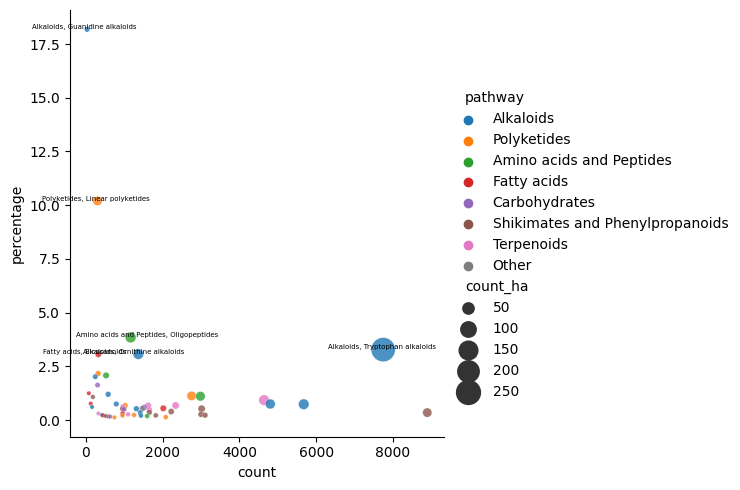

In [24]:
import seaborn as sns

# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=hit_rate,
    x="count", y="percentage",
    hue="pathway", size="count_ha",
    palette='tab10', 
    alpha = 0.8,
    sizes=(10, 300)
)
g.fig.savefig('../plot/4-bubble.svg', transparent=True)


for row in hit_rate.iloc:
    if row['percentage'] > 3:
        x = row['count'] * (0.5577 - 0.167) / 8000 + 0.1
        y = row['percentage'] * (0.892 - 0.141) / 17.5 + 0.151
        text = row['pathway_superclass']
        _ = g.fig.text(x, y, text, fontsize=5)

In [5]:
np_ha.to_csv('../plot/4-np_ha.csv', index=False)
np_ha.shape

(825, 13)

In [6]:
data = np_ha[np_ha['superclass'] == 'Tryptophan alkaloids']
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 254 entries, 25555 to 24739
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   activity_id         254 non-null    int64  
 1   assay_id            254 non-null    int64  
 2   standard_type       254 non-null    object 
 3   pchembl_value       254 non-null    float64
 4   tid                 254 non-null    int64  
 5   target_type         254 non-null    object 
 6   pref_name           254 non-null    object 
 7   class_level         254 non-null    float64
 8   lotus_id            254 non-null    object 
 9   pathway             254 non-null    object 
 10  superclass          254 non-null    object 
 11  class               254 non-null    object 
 12  pathway_superclass  254 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 27.8+ KB


In [7]:
np_ha['superclass'].unique().shape

(46,)

In [8]:
data = np_ha[np_ha['superclass'] == 'Eicosanoids']
data.shape

(10, 13)

In [9]:
data['lotus_id'].value_counts().shape

(4,)

In [10]:
data['lotus_id'].unique().shape

(4,)

In [11]:
data[data['lotus_id'] == 'LTS0171945'].value_counts(subset='pref_name')

Series([], Name: count, dtype: int64)

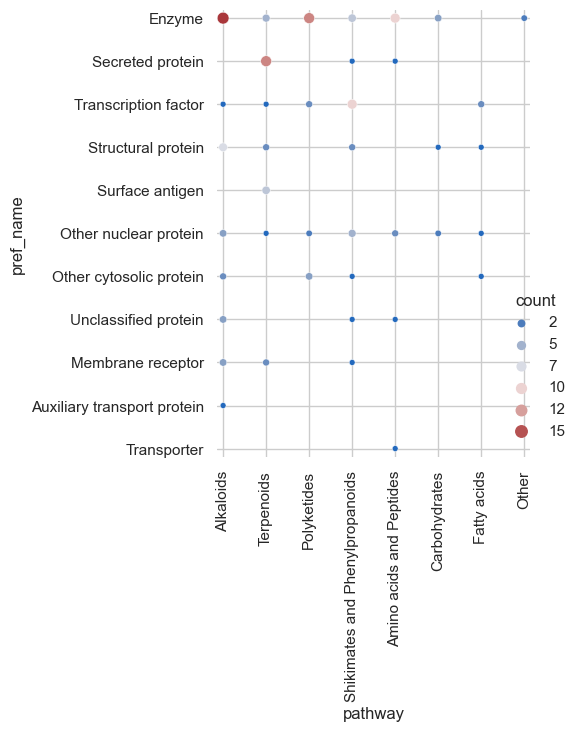

In [12]:
rel_count(np_ha[np_ha['class_level'] == 1], x='pathway', y='pref_name', count_thd = 1, figsize=(5,5))

## value counts based on superclass and tid

In [1]:
import pandas as pd
import igraph as ig
import seaborn as sns
from typing import Sequence
    
def color_tuple_to_rgba(color:tuple, alpha:float=1):
    # color_tuple_to_rgba((0.1, 0.9, 0.1), 0.7) == '#1A659A32'
    # color_tuple_to_rgba((0.0, 0.0, 0.0), 1.0) == '#000000FF'
    return '#' + \
            hex(int(color[0] * 256 * 256 * 256 * 255) + \
                int(color[1] * 256 * 256 * 255) + \
                int(color[2] * 256 * 255) + \
                int(alpha * 255) + \
                256 * 256 * 256 * 256
               ).upper()[3:]

def draw(data, save_path, **kwargs):
    
    # {kw_name : (type, default_value, allows_passing_sequence)}
    valid_keyword: dict = {
        'palette': (str, 'Set1', False),
        'palette_offset': (int, 0, False),
        'alpha': ((float, int), 1, True),
        'size': ((float, int), 9, True),
        'size_offset': ((float, int), 0, False),
        'shape': ((str), 'circle', True),
        'label_size': ((float, int), 12, True),
        'label_dist': ((float, int), 1.3, True),
        'label_angle': ((float, int), [3.1415926, -3.1415926, 0], True)
    }
    
    for kw in kwargs:
        if kw not in valid_keyword:
            raise KeyError(f'{kw} is not a valid keyword. Valid keywords are: {sorted(list(valid_keyword.keys()))}')
    
    # function to get value from kwargs with specified default value
    get_value_from_kwargs = lambda keyword: kwargs.get(keyword, valid_keyword[keyword][1])
    
    trans_dict = {}
    for kw in valid_keyword.keys():
        # get value of this keyword arg
        # valid_keyword[kw][1] is the default value of this keyword arg
        kwarg_value = get_value_from_kwargs(kw)
        
        # valid_keyword[kw][0] is the valid types of this keyword arg
        if isinstance(kwarg_value, valid_keyword[kw][0]):
            # check if this keyword allows passing a sequence
            # valid_keyword[kw][2] is the flag used to specify whether this keyword allows passing a sequence
            if valid_keyword[kw][2]:
                trans_dict[kw] = {
                    'class': kwarg_value,
                    'lotus_id': kwarg_value,
                    'pref_name': kwarg_value
                }
        elif valid_keyword[kw][2] and isinstance(kwarg_value, Sequence):
                trans_dict[kw] = {
                    'class': kwarg_value[0],
                    'lotus_id': kwarg_value[1],
                    'pref_name': kwarg_value[2]
                }
        else:
            raise TypeError
            
    '''
    trans_dict:
    {
        'alpha': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
        'size': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
        'size_offset': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
        'shape': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
        'label_size': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
        'label_dist': {'class': ___, 'lotus_id': ___, 'pref_name': ___}
    }
    '''
    
    # handle color
    palette = get_value_from_kwargs('palette')
    palette_offset = get_value_from_kwargs('palette_offset')
    
    palette = sns.color_palette(palette)[palette_offset: palette_offset+3]
    trans_dict['color'] = {
        'class': color_tuple_to_rgba(palette[0], trans_dict['alpha']['class']),
        'lotus_id': color_tuple_to_rgba(palette[1], trans_dict['alpha']['lotus_id']),
        'pref_name': color_tuple_to_rgba(palette[2], trans_dict['alpha']['pref_name'])
    }
    
    # handle size_offset
    size_offset = get_value_from_kwargs('size_offset')
    for key in trans_dict['size'].keys():
        trans_dict['size'][key] += size_offset
       
    
    # parse data
    df = data[['class', 'lotus_id']]
    df_part_1 = df.drop_duplicates().rename(columns = {'class' : 'from', 'lotus_id' : 'to'}, inplace = False)
    df = data[['lotus_id', 'pref_name']]
    df_part_2 = df.drop_duplicates().rename(columns = {'lotus_id' : 'from', 'pref_name' : 'to'}, inplace = False)
    df = pd.concat([df_part_1, df_part_2])
    
    height = max(len(data[index_name].drop_duplicates()) for index_name in ['class', 'lotus_id', 'pref_name']) * 26
    
    
    # create a Graph object
    g = ig.Graph.TupleList(df.itertuples(index=False), directed=False, vertex_name_attr='name')
    
    
    # node classification
    node_classifier = {}
    for index_name in ['class', 'lotus_id', 'pref_name']:
        node_classifier.update({i : index_name for i in data[index_name]})
    g.vs['class'] = [node_classifier[name] for name in g.vs['name']]
    
    trans_dict['layers'] = {
        'class': 0,
        'lotus_id': 1,
        'pref_name': 2
    }
    
    for key in trans_dict:
        g.vs[key] = [trans_dict[key][class_name] for class_name in g.vs['class']]
    
    # layout
    layout = g.layout_sugiyama(layers=g.vs['layers'], weights=None, hgap=10, vgap=1, maxiter=50, return_extended_graph=False)
    
    layout.rotate(-90)
    
    # plot
    return ig.plot(g, save_path, layout=layout, vertex_label=g.vs['name'], bbox=(0, 0, 768, height), margin=(250, 10, 250, 10))

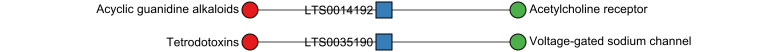

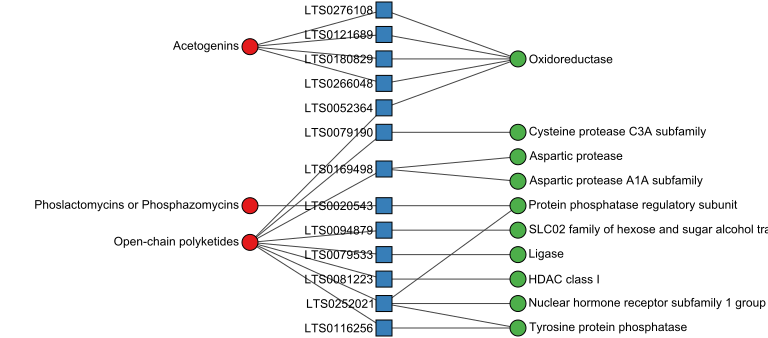

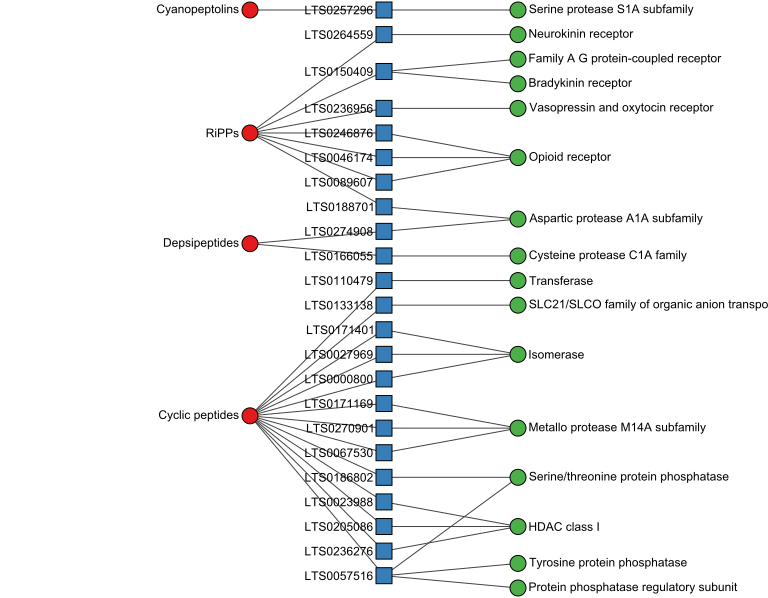

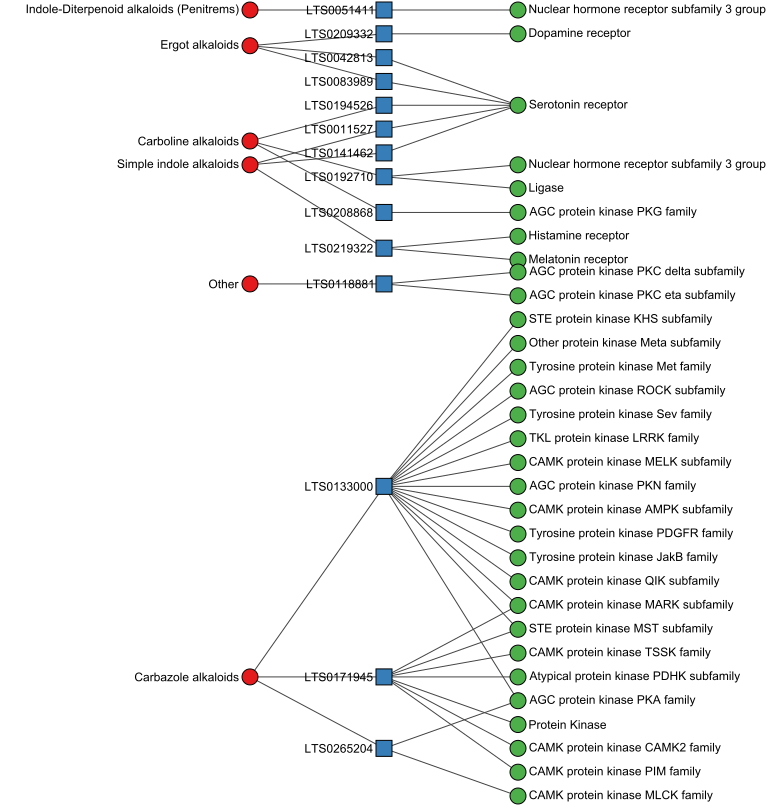

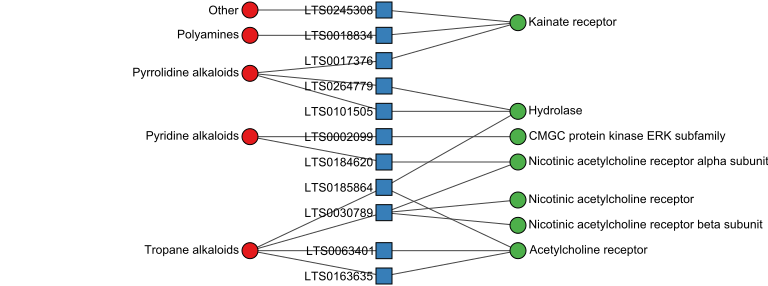

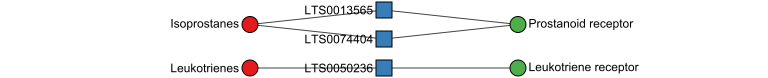

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

np_high_activity = pd.read_csv('../plot/4-np_ha.csv')
hit_rate = pd.read_csv('../plot/4-hit_rate.csv')

pathway_superclass_select = hit_rate[hit_rate['percentage'] > 3]['pathway_superclass'].values

ps = []

for n, pathway_superclass in enumerate(pathway_superclass_select):
    
    cond1 = np_high_activity['pathway_superclass'] == pathway_superclass
    cond2 = np_high_activity['class_level'] >= 2
    data = np_high_activity[cond1 & cond2]
    
    if 'Tryptophan' in pathway_superclass:
        data = data[data['pchembl_value'] > 9]
        
    ps.append(draw(
        data, 
        f'../plot/4-class_target_layerd_network_{pathway_superclass}.svg',
        palette='Set1',
        palette_offset=0,
        alpha=1, 
        shape=['circle', 'rectangle', 'circle'], 
        size=9,
        label_size=12,
        size_offset=7,
        label_dist=1.3
    ))

ps[0]
ps[1]
ps[2]
ps[3]
ps[4]
ps[5]

## Active, inactive, unknown ?

In [16]:
sql = '''SELECT np_activities.* FROM np_activities '''
np_activities = pd.read_sql(sql, conn)

active_id = set(np_activities[np_activities['pchembl_value']>8]['lotus_id'].unique())
print(len(active_id))

inactive_id = set(np_activities['lotus_id'].unique()) - active_id
print(len(inactive_id))

841
35439


In [17]:
np['isActive'] = 'unknown'
np.loc[np['lotus_id'].isin(active_id),'isActive'] = 'active'
np.loc[np['lotus_id'].isin(inactive_id),'isActive'] = 'inactive'
np[np['isActive'] == 'unknown'].shape

(240238, 9)

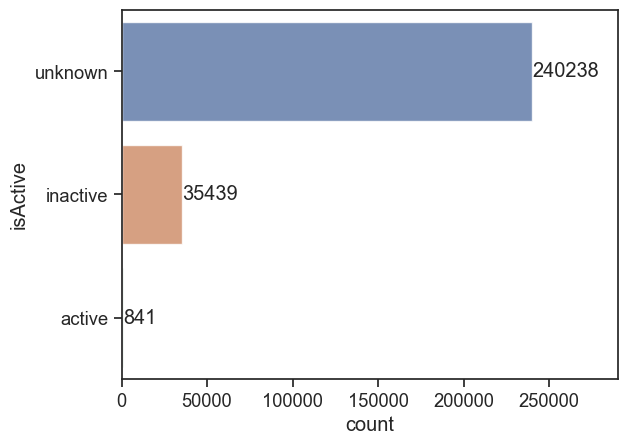

In [18]:
data = np.value_counts(subset='isActive').reset_index()
fig = bar(data, y='isActive', x='count', xlim=(0,290000))
fig.figure.savefig('../plot/4-actvie_inactive.svg', transparent=True)